In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from src.cort_processor import *
from src.plotter import *
from src.filters import *
import math
import pickle
import scipy
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from matplotlib.pyplot import cm
from scipy import signal
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from matplotlib import colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import tdt 
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, iirnotch, filtfilt, resample, hilbert, welch
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
from scipy.io import savemat

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
test_session = CortProcessor('/mnt/c/oobootoo/rat-fes/data/results-meplem923/meepo_fast_923')

read from t=0s to t=384.32s
read from t=0s to t=367.29s


In [3]:
neural = test_session.tdt_data[0]['neural']
fs = test_session.tdt_data[0]['fs']
filtered = filter_neural(neural, fs)
clean_filtered = remove_artifacts(filtered, fs)
tsn = np.linspace(0, neural.shape[0]/fs,neural.shape[0])

In [4]:
means = np.mean(neural, axis = 1)
commonmode = []
for i in range(neural.shape[1]):
    commonhold = neural[:,i] - means
    commonmode.append(commonhold)
commonmode = np.array(commonmode).T

In [5]:
def fresh_filt(neural, lowcut, highcut, fs, order = 5):
    neural = neural.T
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, neural)
    return y.T

In [6]:
commonmode_filttest = fresh_filt(commonmode, 350, 8000, fs, order = 4)

In [7]:
deprcspikes = autothreshold_crossings(clean_filtered, 3.0)
regspikes = autothreshold_crossings(clean_filtered, -3.0)
modespikes = autothreshold_crossings(commonmode, -3.0)
modespikes_filt = autothreshold_crossings(commonmode_filttest, -3.0)

(10169,)
(6880,)
(22598,)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
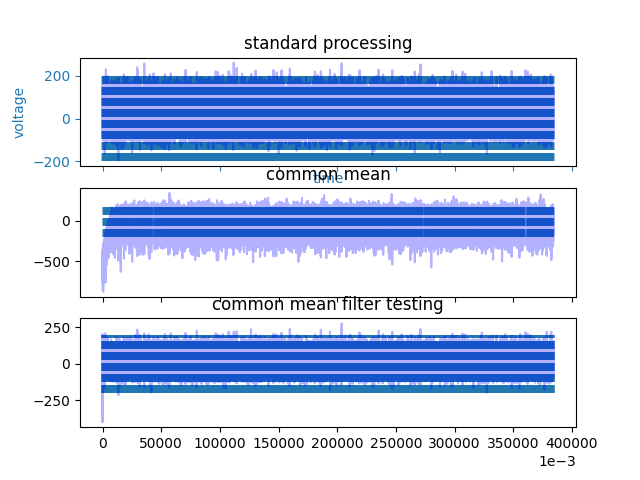

In [8]:
channel = 4
fig, ax=plt.subplots(3,1, sharex=True)
ax[0].plot(tsn, clean_filtered[:,channel],color='b', alpha = 0.3)
line_list = []
for i in range(regspikes.shape[0]):
    if regspikes[i,channel] == 1:
        line_list.append(tsn[i])
print(np.array(line_list).shape)
ax[0].vlines(np.array(line_list), ymin = -200, ymax = 200, color = 'C0', linestyle='--', alpha=0.5)
ax[0].set_xlabel("time", color="C0")
ax[0].set_title("standard processing")
ax[0].set_ylabel("voltage", color="C0")
ax[0].tick_params(axis='x', colors="C0")
ax[0].tick_params(axis='y', colors="C0")
ax[0].ticklabel_format(axis= 'x', style='sci', scilimits= [-3,-3], useOffset=True)

ax[1].plot(tsn, commonmode[:,channel],color='b', alpha = 0.3)
line_list2 = []
for i in range(modespikes.shape[0]):
    if modespikes[i,channel] == 1:
        line_list2.append(tsn[i])
print(np.array(line_list2).shape)
ax[1].vlines(np.array(line_list2), ymin = -200, ymax = 200, color = 'C0', linestyle='--', alpha=0.5)
ax[1].set_title("common mean")


ax[2].plot(tsn, commonmode_filttest[:,channel],color='b', alpha = 0.3)
line_list3 = []
for i in range(modespikes_filt.shape[0]):
    if modespikes_filt[i,channel] == 1:
        line_list3.append(tsn[i])
print(np.array(line_list3).shape)
ax[2].vlines(np.array(line_list3), ymin = -200, ymax = 200, color = 'C0', linestyle='--', alpha=0.5)
ax[2].set_title("common mean filter testing")

plt.show()

(28051,)
(22598,)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
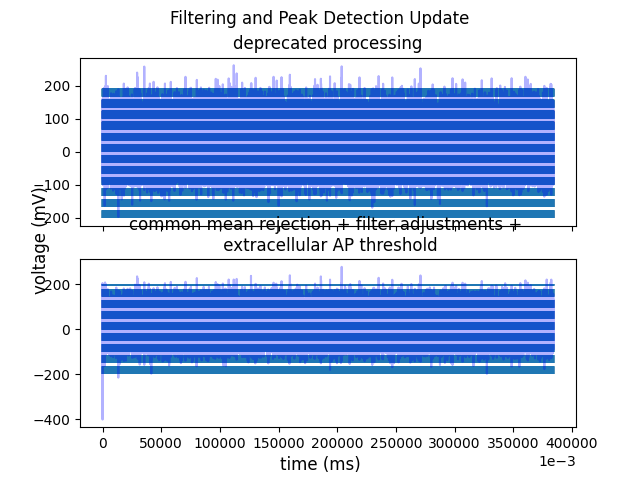

In [9]:
channel = 4
fig12, ax=plt.subplots(2,1, sharex=True)
ax[0].plot(tsn, clean_filtered[:,channel],color='b', alpha = 0.3)
line_list = []
for i in range(deprcspikes.shape[0]):
    if deprcspikes[i,channel] == 1:
        line_list.append(tsn[i])
print(np.array(line_list).shape)
ax[0].vlines(np.array(line_list), ymin = -200, ymax = 200, color = 'C0', linestyle='--', alpha=0.5)
ax[0].set_title("deprecated processing")
ax[0].ticklabel_format(axis= 'x', style='sci', scilimits= [-3,-3], useOffset=True)

ax[1].plot(tsn, commonmode_filttest[:,channel],color='b', alpha = 0.3)
line_list3 = []
for i in range(modespikes_filt.shape[0]):
    if modespikes_filt[i,channel] == 1:
        line_list3.append(tsn[i])
print(np.array(line_list3).shape)
ax[1].vlines(np.array(line_list3), ymin = -200, ymax = 200, color = 'C0', linestyle='--', alpha=0.5)
ax[1].set_title("common mean rejection + filter adjustments + \n extracellular AP threshold")
fig12.suptitle('Filtering and Peak Detection Update')
fig12.tight_layout
fig12.text(.5,.02, 'time (ms)', ha = 'center', size = 'large')
fig12.text(0.05,.5, 'voltage (mV)', va='center', rotation='vertical', size = 'large')
plt.show()

In [10]:
fq0, p0 = scipy.signal.welch(commonmode[:,4], fs = fs, nperseg = 100000)
fq1, p1 = scipy.signal.welch(commonmode_filttest[:,4], fs = fs, nperseg = 100000)
fq2, p2 = scipy.signal.welch(neural[:,4], fs = fs, nperseg = 100000)
fq3, p3 = scipy.signal.welch(clean_filtered[:,4], fs = fs, nperseg = 100000)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
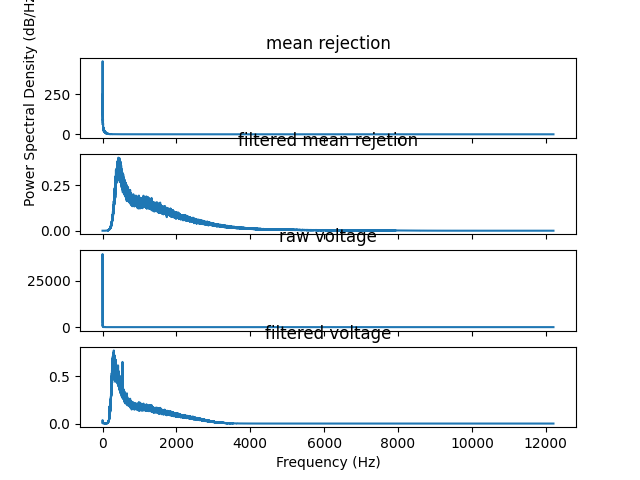

In [11]:
fig5, ax5=plt.subplots(4,1, sharex=True)
ax5[0].plot(fq0, p0)
ax5[0].set_title('mean rejection')
ax5[0].set_ylabel('Power Spectral Density (dB/Hz)')
# ax5[0].set_xlabel('Frequency (Hz)')
ax5[1].plot(fq1, p1)
ax5[1].set_title('filtered mean rejetion')
# ax5[1].set_ylabel('Power Spectral Density (dB/Hz)')

ax5[2].plot(fq2, p2)
ax5[3].plot(fq3, p3)
ax5[2].set_title('raw voltage')
ax5[3].set_title('filtered voltage')
ax5[3].set_xlabel('Frequency (Hz)')
plt.show()